## Imports

In [19]:
from skorch import NeuralNetRegressor

import torch
import torch.nn as nn

import numpy as np

from TurbulenceNetwork import TurbulenceNetwork
from TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from plot_utils import plot_data_generation_diff, plot_heat_map

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Misc Utilities

In [2]:
class MAPELoss:
    def __init__(self, *args, **kwargs):
        self.eta = 1e-5
        pass

    def __call__(self, y_pred, y_true):
        l = torch.abs((y_true - y_pred)) / (torch.abs(y_true)) * 100

        return torch.mean(l)


## Data Generation

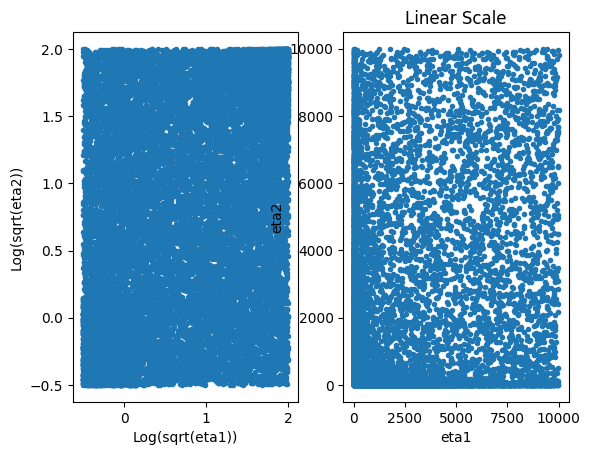

In [20]:
LLR_gen = TurbulenceClosureDataGenerator('LRR')
SSG_gen = TurbulenceClosureDataGenerator('SSG')
SZL_gen = TurbulenceClosureDataGenerator('SZL')

log_narrow = (-.5, .15)
log = (-.5, 2)
lin = (.1, 10_000)

# Generating data on a narrowed log scale
LLR_x_log_narrow, LLR_y_log_narrow = LLR_gen((10**np.random.uniform(*log_narrow, 10))**2, (10**np.random.uniform(*log_narrow, 10))**2)
SSG_x_log_narrow, SSG_y_log_narrow = SSG_gen((10**np.random.uniform(*log_narrow, 10_000))**2, (10**np.random.uniform(*log_narrow, 10_000))**2)
SZL_x_log_narrow, SZL_y_log_narrow = SZL_gen((10**np.random.uniform(*log_narrow, 10))**2, (10**np.random.uniform(*log_narrow, 10))**2)

# Generating data on a log scale
LLR_x_log, LLR_y_log = LLR_gen((10**np.random.uniform(*log, 10))**2, (10**np.random.uniform(*log, 10))**2)
SSG_x_log, SSG_y_log = SSG_gen((10**np.random.uniform(*log, 14_000))**2, (10**np.random.uniform(*log, 14_000))**2)
SZL_x_log, SZL_y_log = SZL_gen((10**np.random.uniform(*log, 10))**2, (10**np.random.uniform(*log, 10))**2)

# Generating data on a linear scale
LLR_x_lin, LLR_y_lin = LLR_gen(np.random.uniform(*lin, 10), np.random.uniform(*lin, 10))
SSG_x_lin, SSG_y_lin = SSG_gen(np.random.uniform(*lin, 3_000), np.random.uniform(*lin, 3_000))
SZL_x_lin, SZL_y_lin = SZL_gen(np.random.uniform(*lin, 10), np.random.uniform(*lin, 10))

x = np.concatenate((
    LLR_x_log_narrow, SSG_x_log_narrow, SZL_x_log_narrow,
    LLR_x_log, SSG_x_log, SZL_x_log,
    SSG_x_lin, LLR_x_lin, SZL_x_lin
    ))
y = np.concatenate((
    LLR_y_log_narrow, SSG_y_log_narrow, SZL_y_log_narrow,
    LLR_y_log, SSG_y_log, SZL_y_log,
    SSG_y_lin, LLR_y_lin, SZL_y_lin
    ))

plot_data_generation_diff(np.log10(np.sqrt(x)))

total = np.concatenate((x, y), axis=1)

np.random.shuffle(total)

x = total[:, :2]
y = total[:, 2:]

x_test_LLR , y_test_LLR = LLR_gen(np.random.uniform(.1, 10_000, 1_000), np.random.uniform(.1, 10_000, 1_000))
x_test_SSG , y_test_SSG = SSG_gen(np.random.uniform(.1, 10_000, 1_000), np.random.uniform(.1, 10_000, 1_000))
x_test_SZL , y_test_SZL = SZL_gen(np.random.uniform(.1, 10_000, 1_000), np.random.uniform(.1, 10_000, 1_000))

x_test = np.concatenate((x_test_LLR, x_test_SSG, x_test_SZL))
y_test = np.concatenate((y_test_LLR, y_test_SSG, y_test_SZL))


## Network Training

In [ ]:
net = NeuralNetRegressor(TurbulenceNetwork(input_dim=2, output_dim=3, num_layers=7, nodes=[7, 7, 7, 7, 7, 7, 7]),
                            criterion=nn.L1Loss,
                            optimizer=torch.optim.Adam,
                            lr=0.0001,
                            batch_size=64,
                            max_epochs=400,
                            device=device,
                            iterator_train__shuffle=True,
                            iterator_train__num_workers=4,
                            iterator_train__pin_memory=True,
                            iterator_valid__shuffle=False,
                            iterator_valid__num_workers=4,
                            iterator_valid__pin_memory=True,
)

net = net.fit(x, y)

torch.save(net.module.state_dict(), "TurbulenceNetwork.pt")

plot_heat_map(net)

y_pred = net.predict(x_test)
loss = MAPELoss()(torch.tensor(y_pred), torch.tensor(y_test))
print(f"Absolute Test Loss after 30 epochs: {loss}")
